<a href="https://colab.research.google.com/github/jmvgmr/Python/blob/master/GamePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

data = pd.read_csv('/content/Data/atp_data.csv', low_memory=False)
data.Date = data.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [24]:
print('Total number of matches: ',str(len(data)))

Total number of matches:  46584


In [25]:
print(list(data.columns))

['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L', 'elo_winner', 'elo_loser', 'proba_elo']


In [0]:
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=120)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

In [57]:
beg = datetime(2010,1,1)
end = data.Date.iloc[-1]
indices = data[(data.Date > beg) & (data.Date <= end)].index
data_sel = data[['B365W','B365L','PSW','PSL','WRank','LRank']]
data_sel = data.iloc[indices,:]
print('Number of matches during this period: ',len(data_sel))

Number of matches during this period:  26791


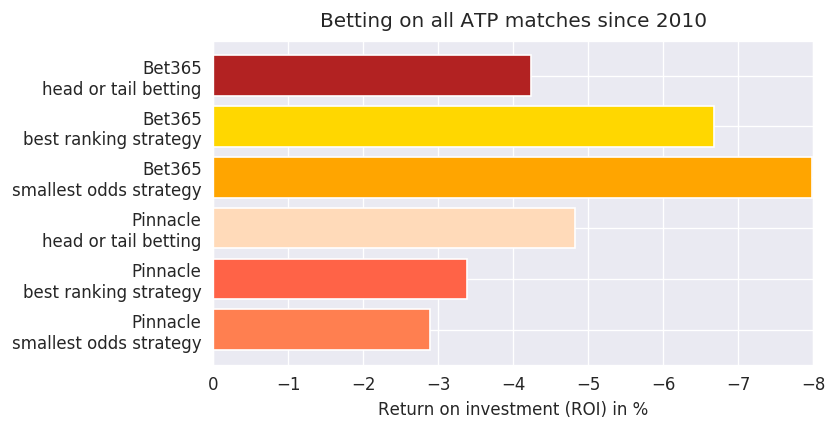

In [58]:
#Comparison of some basic strategies
roi_smallest_odd_ps = 100*(data_sel.PSW[data_sel.PSW < data_sel.PSL].sum() - len(data_sel))/len(data_sel)
roi_best_ranking_ps = 100*(data_sel.PSW[data_sel.WRank < data_sel.LRank].sum() - len(data_sel))/len(data_sel)
roi_random_ps = 100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum() - len(data_sel))/len(data_sel)
roi_smallest_odd_365 = 100*(data_sel.B365W[data_sel.B365W < data_sel.B365L].sum() - len(data_sel))/len(data_sel)
roi_best_ranking_365 = 100*(data_sel.B365W[data_sel.WRank < data_sel.LRank].sum() - len(data_sel))/len(data_sel)
roi_random_365 = 100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum() - len(data_sel))/len(data_sel)
values = [roi_smallest_odd_ps, roi_best_ranking_ps, roi_random_ps, roi_smallest_odd_365, roi_best_ranking_365, roi_random_365]
labels = ['Pinnacle\nsmallest odds strategy', 'Pinnacle\nbest ranking strategy', 'Pinnacle\nhead or tail betting',
          'Bet365\nsmallest odds strategy', 'Bet365\nbest ranking strategy', 'Bet365\nhead or tail betting']
xaxis_label = 'Return on investment (ROI) in %'
title = 'Betting on all ATP matches since 2010'
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,-8],(5,3))

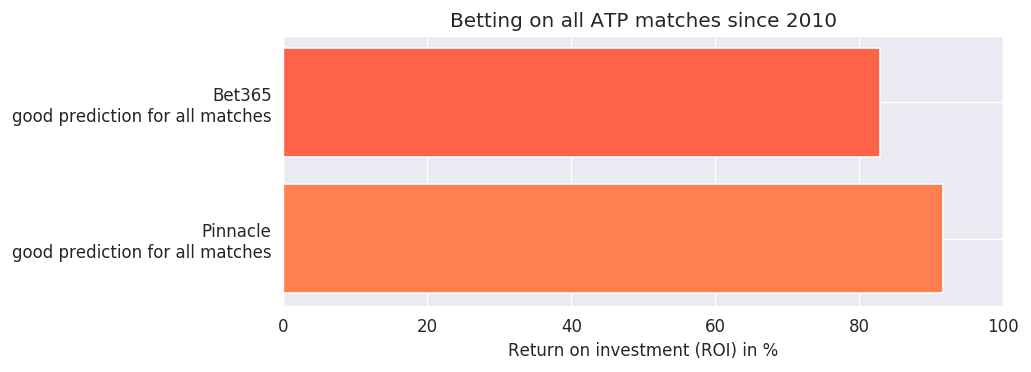

In [59]:
#Maximum possible ROI
max_roi_ps = 100*(data_sel.PSW.sum() - len(data_sel))/len(data_sel)
max_roi_365 = 100*(data_sel.B365W.sum() - len(data_sel))/len(data_sel)
values = [max_roi_ps, max_roi_365]
labels=['Pinnacle\ngood prediction for all matches','Bet365\ngood prediction for all matches']
xaxis_label='Return on investment (ROI) in %'
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,100],(6,2.5))

In [0]:
def profitComputation(percentage_matchs, conf, model_name='0'):
    """
    Given a confidence dataset and a percentage of matches, computes the ROI 
    if we bet only on the percentage of matches we have the most confidence in
    (same amount for each match).
    """
    coeff = percentage_matchs/100
    lim = int(coeff*len(conf))
    conf = conf.sort_values('confidence'+model_name, ascending=False)
    conf = conf.iloc[:lim,:]
    profit = 100*(conf.PSW[conf['win'+model_name] == 1].sum() - len(conf))/len(conf)
    return profit

def plotProfits(conf, title=''):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,conf)
        profits.append(p)
    fig=plt.figure(figsize=(6,4),dpi=120)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    plt.show()

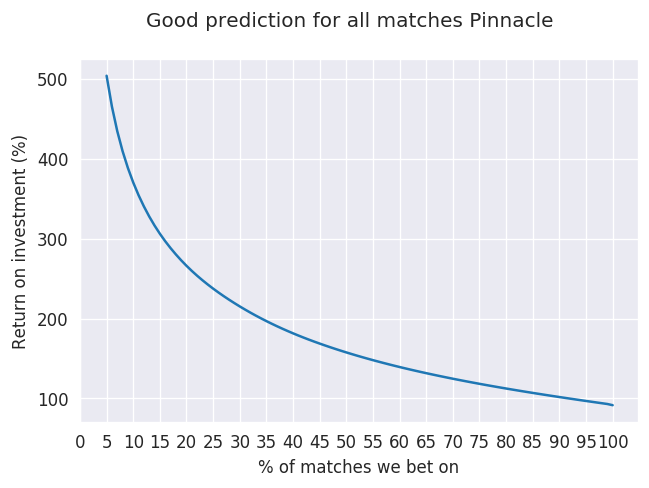

In [61]:
perfect_conf = pd.concat([data_sel[['Date','PSW','PSL']]],1)
perfect_conf['win0'] = [1]*len(perfect_conf)
perfect_conf['confidence0'] = perfect_conf.PSW
perfect_conf = perfect_conf.rename(columns = {'Date':'date'})
plotProfits(perfect_conf, 'Good prediction for all matches Pinnacle')

In [62]:
#Our predictions + confidence level + if we were right or not
conf = pd.read_csv('/content/Data/confidence_data.csv')
print('Total number of matches predicted: ' + str(len(conf)))

Total number of matches predicted: 18754


In [63]:
conf.iloc[:6,:]

,match,PSW,win0,confidence0,date
0,31305,1.33,0,2.332264,2019-09-17
1,24833,1.38,0,2.221230,2017-05-01
2,30688,1.34,0,2.144539,2019-07-03
3,30515,1.40,0,2.107244,2019-06-18
4,14627,1.27,0,2.100982,2013-05-26
5,22806,1.45,0,2.100599,2016-06-30


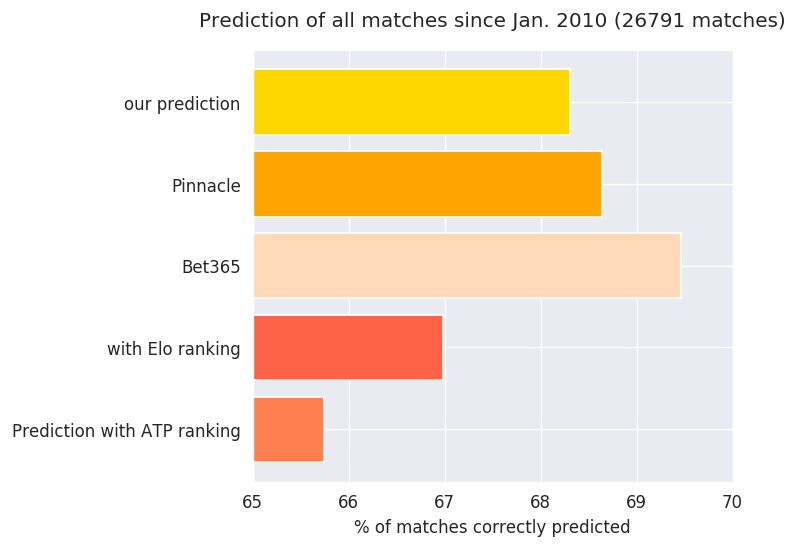

In [64]:
#Comparison of different techniques for the winner prediction
#Interval for the comparison: [beg, end]
beg = datetime(2010,1,1)
end = data.Date.iloc[-1]
indices = data[(data.Date >= beg) & (data.Date <= end)].index
#Classic ATP ranking
test = data[['WRank','LRank']].iloc[indices,:]
atp = 100*(test.LRank > test.WRank).sum()/len(indices)
#Elo ranking
test = data.iloc[indices,:]
elo = 100*(test.elo_winner > test.elo_loser).sum()/len(indices)
#Bookmakers
test = data.iloc[indices,:]
book_pi = 100*(test.PSW < test.PSL).sum()/len(indices)
book_365 = 100*(test.B365W < test.B365L).sum()/len(indices)
#Our prediction
our = 100*conf.win0.sum()/len(conf)
#Plot
labels=["Prediction with ATP ranking","with Elo ranking",
        "Bet365","Pinnacle",
        "our prediction"]
values=[atp,elo,book_pi,book_365,our]
xaxis_label="% of matches correctly predicted"
title="Prediction of all matches since Jan. 2010 ("+str(len(indices))+" matches)"
xlim=[65,70]
basic_horizontal_barplot(values,labels,xaxis_label,title,xlim,figsize=(4,4))

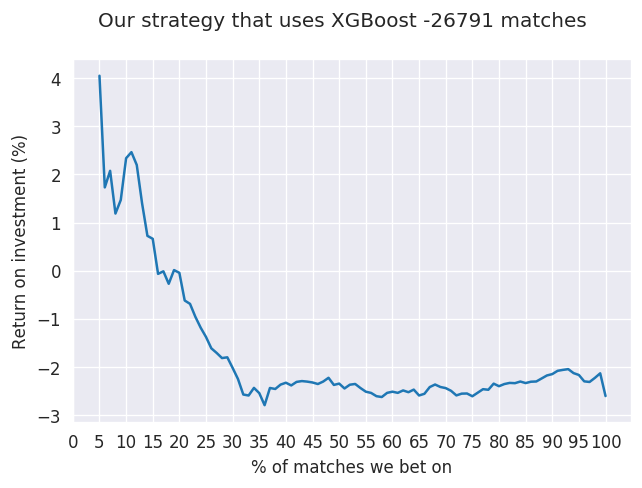

In [65]:
plotProfits(conf,title='Our strategy that uses XGBoost -' + str(len(indices)) + ' matches')

In [0]:
def profitsAlongTime(conf,matches_delta):
    span_matches= conf.match.max() - conf.match.min() - 1
    N = int(span_matches/matches_delta) + 1
    milestones = np.array([conf.match.min() + matches_delta*i for i in range(N)])
    profits = []
    lens = []
    for i in range(N - 1):
        beg = milestones[i]
        end = milestones[i + 1] - 1
        conf_sel = confconf[(conf.match >= beg) & (conf.match <= end)]
        l = len(conf_sel)
        lens.append(l)
        if l == 0:
            profits.append(0)
        else:
            p = profitComputation(100,conf_sel)
            profits.append(p)
    profits = np.array(profits)
    return profits,lens

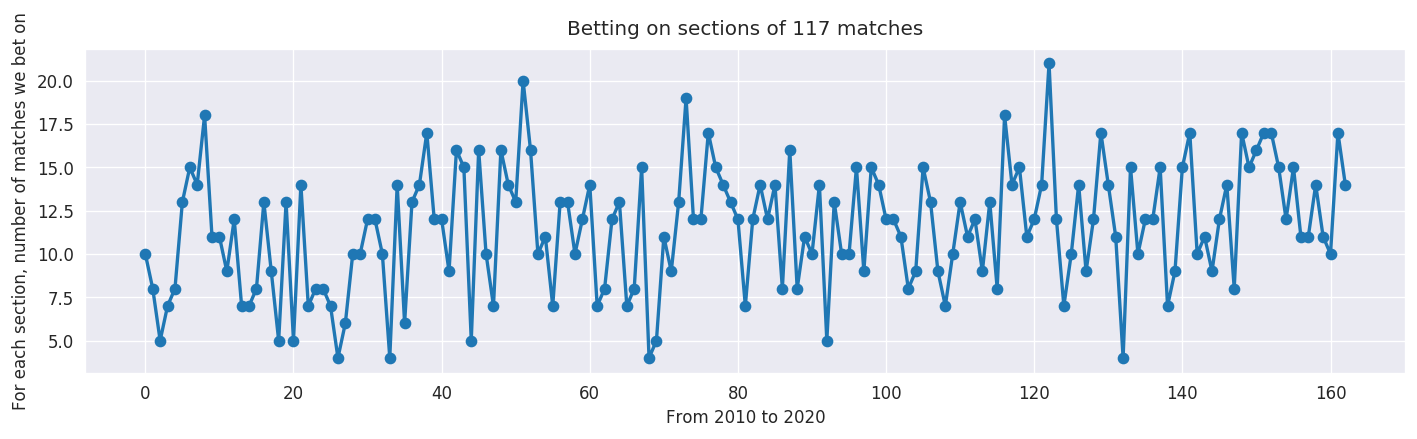

In [96]:
confconf = conf.iloc[:int(0.1*len(conf)),:]
profits,lens = profitsAlongTime(confconf,115)
fig = plt.figure(figsize=(11,3),dpi=120)
ax = fig.add_axes([0,0,1,0.9])
ax.plot(lens,linewidth=2, marker='o')
plt.suptitle('Betting on sections of 117 matches')
ax.set_xlabel('From 2010 to 2020')
ax.set_ylabel('For each section, number of matches we bet on')
plt.show()

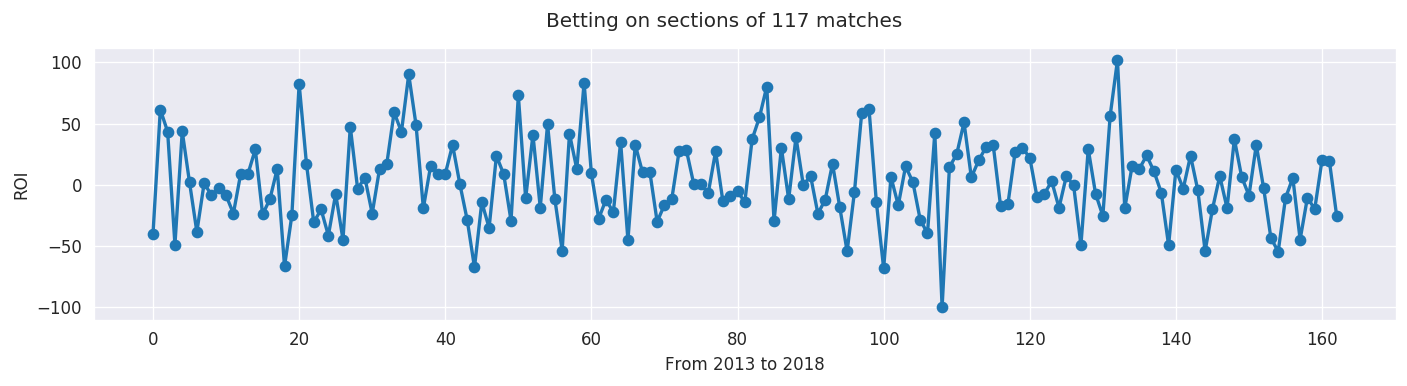

In [97]:
conf10 = conf.iloc[:int(0.1*len(conf)),:]
profits,lens = profitsAlongTime(conf10,115)
fig=plt.figure(figsize=(14,3),dpi=120)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2010 to 2018")
plt.ylabel("ROI")
plt.show()

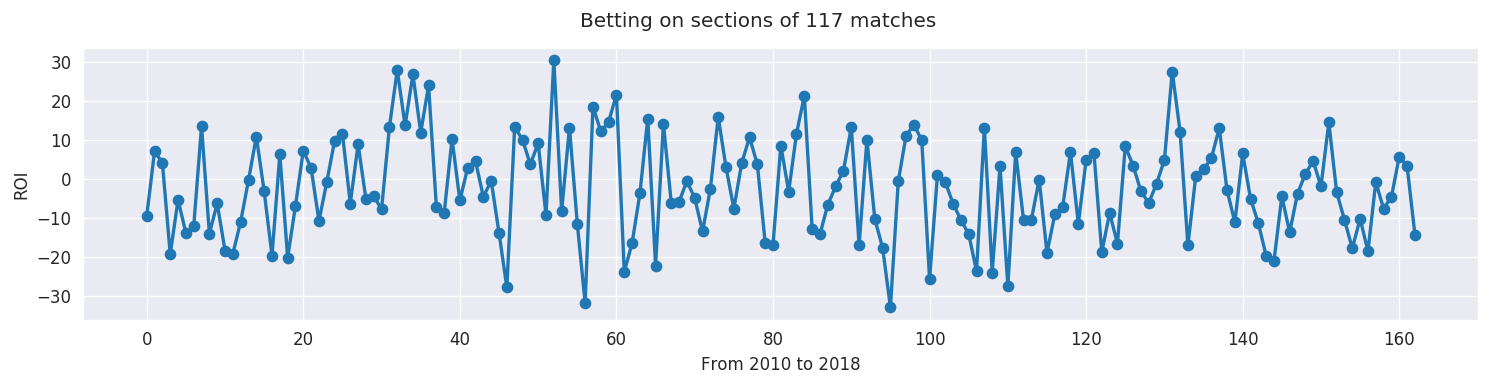

In [98]:
confconf = conf.iloc[:int(0.35*len(conf)),:]
profits,lens=profitsAlongTime(confconf,115)
fig=plt.figure(figsize=(15,3),dpi=120)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2010 to 2018")
plt.ylabel("ROI")
plt.show()

In [99]:
print('Standard deviation: ' + str(round(profits.std(),1)))

Standard deviation: 12.8
